In [1]:
#Modules
import re
import csv
import math
import itertools

import numpy as np
import pandas as pd
import networkx as nx
import pathway_analysis as pa

# Submodules
from cdlib import algorithms
from matplotlib import pyplot as plt

# Class and functions
from copy import deepcopy
from collections import defaultdict

Note: to be able to use all crisp methods, you need to install some additional packages:  {'graph_tool', 'leidenalg', 'wurlitzer', 'infomap'}
Note: to be able to use all overlapping methods, you need to install some additional packages:  {'ASLPAw'}
Note: to be able to use all bipartite methods, you need to install some additional packages:  {'leidenalg', 'wurlitzer', 'infomap'}


In [2]:
pathways = ["hsa00130", "hsa00260", "hsa00270", "hsa00350",
            "hsa00360", "hsa00400", "hsa00670", "hsa00790"]

In [3]:
dis_gene = pd.read_csv('disease-gene.csv')
dis_gene

,gene_name,disease
0,FAH,tyrosinemia I
1,TAT,tyrosinemia II
2,HPD,tyrosinemia III
3,HGD,alkaptonuria
4,PAH,phenylketonuria
5,CBS,homocystinuria
6,MTHFR,homocystinuria
7,MTR,homocystinuria
8,GCSH,homocystinuria
9,AMT,nonketotic hyperglycinemia


### Build the graph

In [4]:
nodes = []
interactors = []
G = nx.DiGraph()

for p in pathways:
    path = p + "/" + p + "nodes.txt"
    with open(path) as f:
        lines = f.readlines()

    for line in lines:
        names = np.array([])
        diseases = np.array([])
        line = line.replace('"', "")
        line = line.replace(" ", "")
        line = line.replace("\n", "")
        line = re.sub('\[.*?]', '', line)
        line = line.split(",")

        for i in range(len(line)):
            names = np.append(names, line[i])

        for index, row in dis_gene.iterrows():
            if(line[0] == row['gene_name']):
                diseases = np.append(diseases, row['disease'])
                break

        if diseases.size == 0:
            diseases = np.append(diseases, 'none')

        G.add_node(line[0], names = names, diseases = diseases, module = set())

    path = p + "/" + p + "edges.txt"
    with open(path) as f:
        lines = f.readlines()

    for line in lines:
        line = line.replace('"', "")
        line = line.replace(" ", "")
        line = line. rstrip('\n')
        line = re.sub('\[.*?]', '', line)
        line = line.split(",")
        interactors.append((line[0], p))


edges = []

for i in range(0, len(interactors), 2):
    edge = (interactors[i][0], interactors[i + 1][0])
    G.add_edge(edge[0], edge[1], pathway = interactors[i][1])

In [5]:
# Color map of the nodes
color_state_map_nodes = {
    'alkaptonuria': 'red',
    'tyrosinemia I': 'black',
    'tyrosinemia II': 'black',
    'tyrosinemia III': 'black',
    'phenylketonuria': 'green',
    'homocystinuria': 'yellow',
    'nonketotic hyperglycinemia': "orange",
    'none': 'blue',
    'expanded': 'gray'}

color_state_map_edges = {
    'hsa00130': 'blue',
    'hsa00260':'red',
    'hsa00270':'yellow',
    'hsa00350':'orange',
    'hsa00360':'black',
    'hsa00400':'blue',
    'hsa00670':'green',
    'hsa00790':'purple',
    'ppi':'gray'}

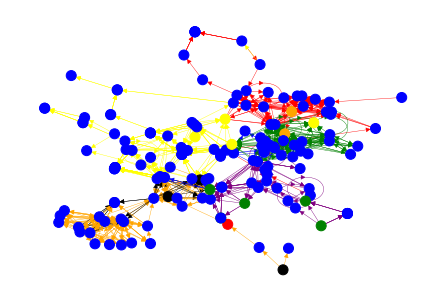

In [6]:
nx.draw(G, pos = nx.kamada_kawai_layout(G), with_labels = False,
        node_color=[color_state_map_nodes[node[1]['diseases'][0]] for node in G.nodes(data=True)],
        width = 0.4, node_size = 100,
        edge_color=[color_state_map_edges[edge[2]['pathway']] for edge in G.edges(data =True)])


In [7]:
print('Number of nodes: ', G.number_of_nodes())
print('Number of edges: ', G.number_of_edges())

Number of nodes:  156
Number of edges:  742


In [8]:
# Add the color attribute
nx.set_node_attributes(G, 'blue', 'color')

# Add a flag to indicate that it is a disease node
nx.set_node_attributes(G, False, 'disease')
for gene_name in dis_gene['gene_name']:
    G.nodes[gene_name]['disease'] = True
    G.nodes[gene_name]['color'] = 'red'

### Use BioGRID names

In [9]:
# NOTA! ci sono degli alias, in questo modo perdiamo due nodi!
aliases = {}
with open('aliases_2353463.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    for row in csv_reader:
        if len(row) > 2: # This is due to a bug
            continue
        aliases[row[0]] = row[1]

# How many nodes do we lose?
l = []
# For each node, get its corresponding name in biogrid
for n in G.nodes():
    l.append(aliases.get(n))

import collections
print([(item, count) for item, count in collections.Counter(l).items() if count > 1])

[('PGAM4', 2), (None, 4), ('ADH7', 2)]


In [10]:
pa.relabel_node_with_aliases(G)

In [11]:
dis_gene['gene_name'] = dis_gene['gene_name'].apply(
    lambda x: aliases[x] if aliases.get(x) is not None else x)

In [12]:
G_un = nx.Graph(G)
pa.remove_self_loop(G_un)
pa.print_graph_properties(G_un)

Number of nodes: 154
Number of edges: 622
Density: 0.053
Is connected: False
Number of connected components: 6
Largest connected component: 141 (0.92%)
Number of isolated nodes: 2 (0.01%)
Number of self loops: 0


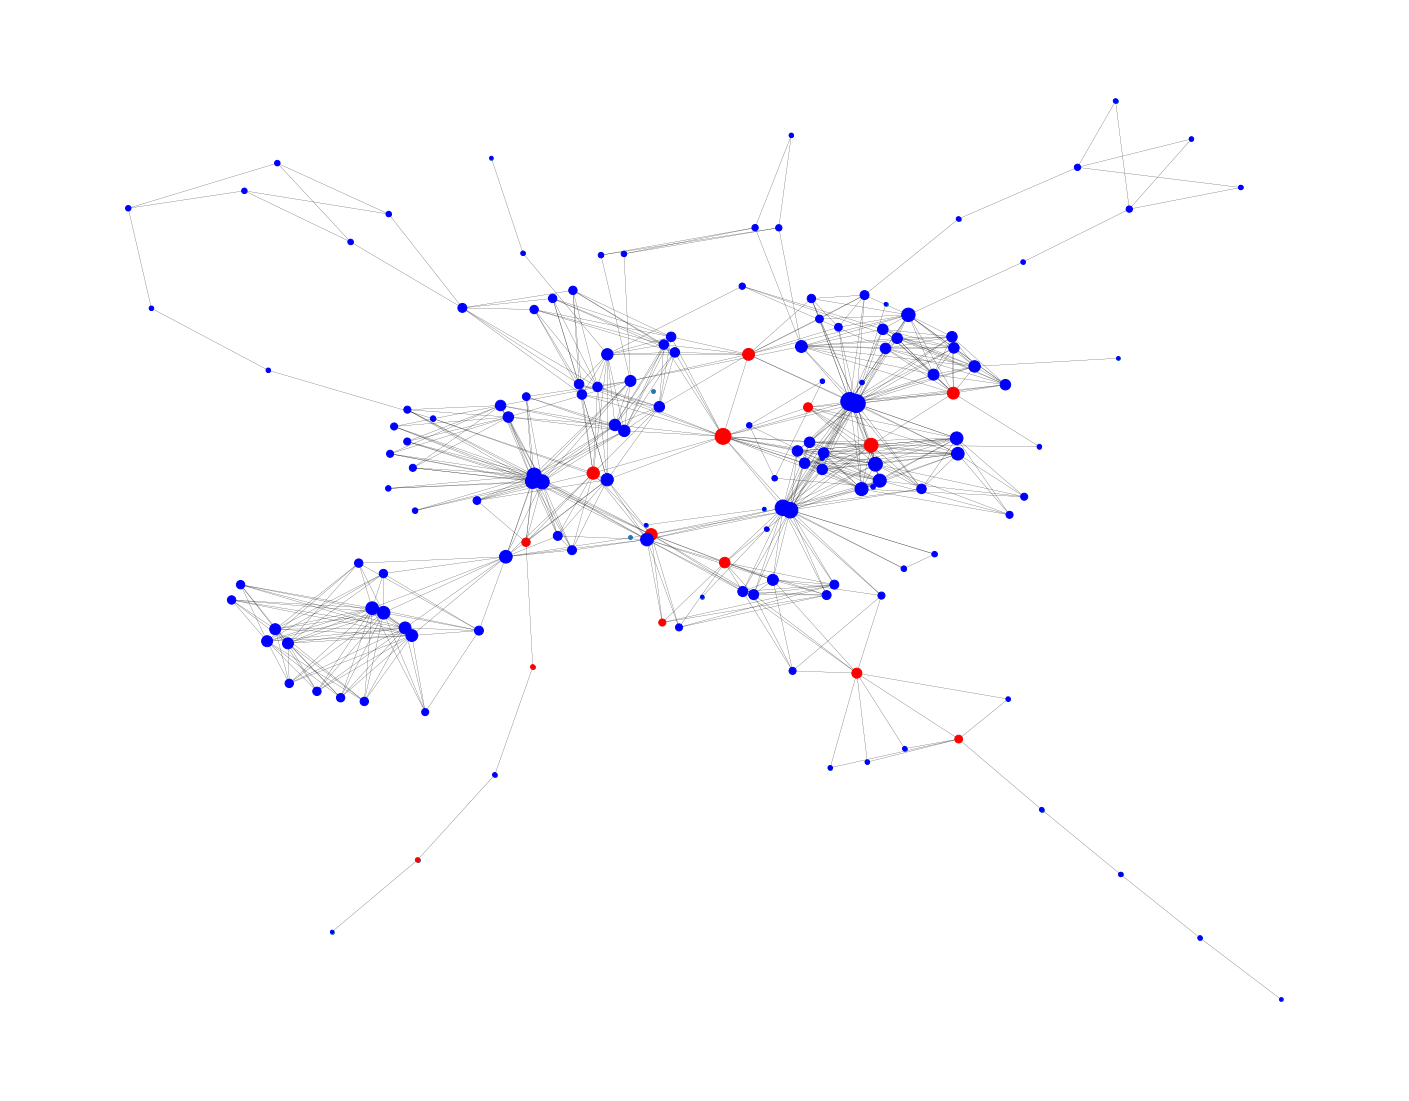

In [13]:
fig, ax = plt.subplots(1)
fig.set_size_inches(25, 20)
pos = nx.kamada_kawai_layout(G_un)
nx.draw(
    G_un,
    pos=pos,
    width=0.2, node_size=15, arrowsize=10, ax=ax
)

nx.draw_networkx_nodes(G_un, pos, node_shape='o',
                       node_size=[len(list(G_un.neighbors(x)))*10 for x in G_un.nodes()],
                       node_color=[color
                            for x, color in G_un.nodes(data='color')], ax=ax)


### Expand the graph

Number of nodes: 6144
Number of edges: 338449
Density: 0.018
Is connected: True
Number of connected components: 1
Largest connected component: 6144 (1.00%)
Number of isolated nodes: 0 (0.00%)
Number of self loops: 8


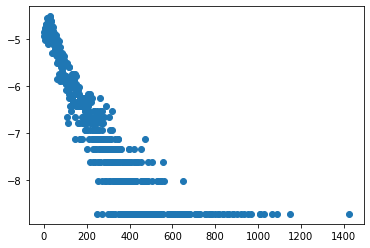

In [14]:
G_exp = deepcopy(G_un)

# Expand
pa.expand_with_neighbours(G_exp)

# Remove self loops
pa.remove_self_loop(G_exp)

# Get main connected component
G_cc = pa.get_main_connected_component(G_exp)

# Prune
pa.pruning_0(G_cc)

# Relabel
pa.relabel_node_with_aliases(G_cc)

### Plot scale free property
n_neig = sorted([len(list(G_cc.neighbors(n))) for n in G_cc.nodes()])
n_neig = np.array(n_neig)
p = []
for i in range(1, n_neig[-1]+1):
    p.append(len(n_neig[n_neig == i])/len(n_neig))
plt.scatter(range(len(p)), np.log(np.array(p)))
pa.print_graph_properties(G_cc)

### Get drug targets
* df_drugs1: dataframe with DrugID and GeneName indicating the targets of that drug;
* df_drugs2: dataframe with DrugID and Status indicating the currest status of that drug;
* df_drugs3: dataframe with DrugId and DrugName

In [15]:
import pickle
infile = open('drugs_data/drug_gene_names', 'rb')
drug_genes = pickle.load(infile)
infile.close()

In [16]:
list_drug_genes = []
for key in drug_genes.keys():
    for gene in drug_genes[key]:
        list_drug_genes.append([key, gene])
df_drugs1 = pd.DataFrame(list_drug_genes, columns=['DrugID', 'GeneName'])
print('Number of druggable targets:', df_drugs1['GeneName'].nunique())

Number of druggable targets: 2407


In [17]:
df_drugs1['GeneName'] = df_drugs1['GeneName'].apply(
    lambda x: aliases[x] if aliases.get(x) is not None else x)
print('Number of druggable targets:', df_drugs1['GeneName'].nunique())

Number of druggable targets: 2389


In [18]:
df_drugs2 = pd.read_csv('drugs_data/drug_target.csv', sep='\t', index_col=0)
df_drugs2.rename(columns={'Highest_status': 'Status'}, inplace=True)
df_drugs2 = df_drugs2.loc[:, ['DrugID', 'Status']]

In [19]:
df_drugs = pd.merge(df_drugs1, df_drugs2, on='DrugID')

In [20]:
df_drugs3 = pd.read_csv('drugs_data/drug_names.txt', sep='\t', skiprows=22, header=None)
df_drugs3.dropna(inplace=True)
df_drugs3 = df_drugs3[df_drugs3.iloc[:, 1] == 'DRUGNAME']
df_drugs3.rename(columns={0: 'DrugID', 2:'DrugName'}, inplace=True)
df_drugs3 = df_drugs3.iloc[:, [0, 2]]

In [21]:
df_drugs = pd.merge(df_drugs, df_drugs3)
df_drugs.to_csv('drugs.csv')

In [22]:
# Get just the approved
df_drugs_approved = df_drugs[df_drugs['Status'] == 'Approved']

### Map drug targets in the network

In [23]:
targets_in_the_network = set(df_drugs_approved['GeneName']).intersection(G_cc.nodes())
print('There are %d targets in the network' %len(targets_in_the_network))
nx.set_node_attributes(G_cc, False, 'target')
for target in targets_in_the_network:
    G_cc.nodes[target]['target'] = True

There are 182 targets in the network


### Plot the graph

In [24]:
# Use G_copy just for the name
G_copy = deepcopy(G_cc)

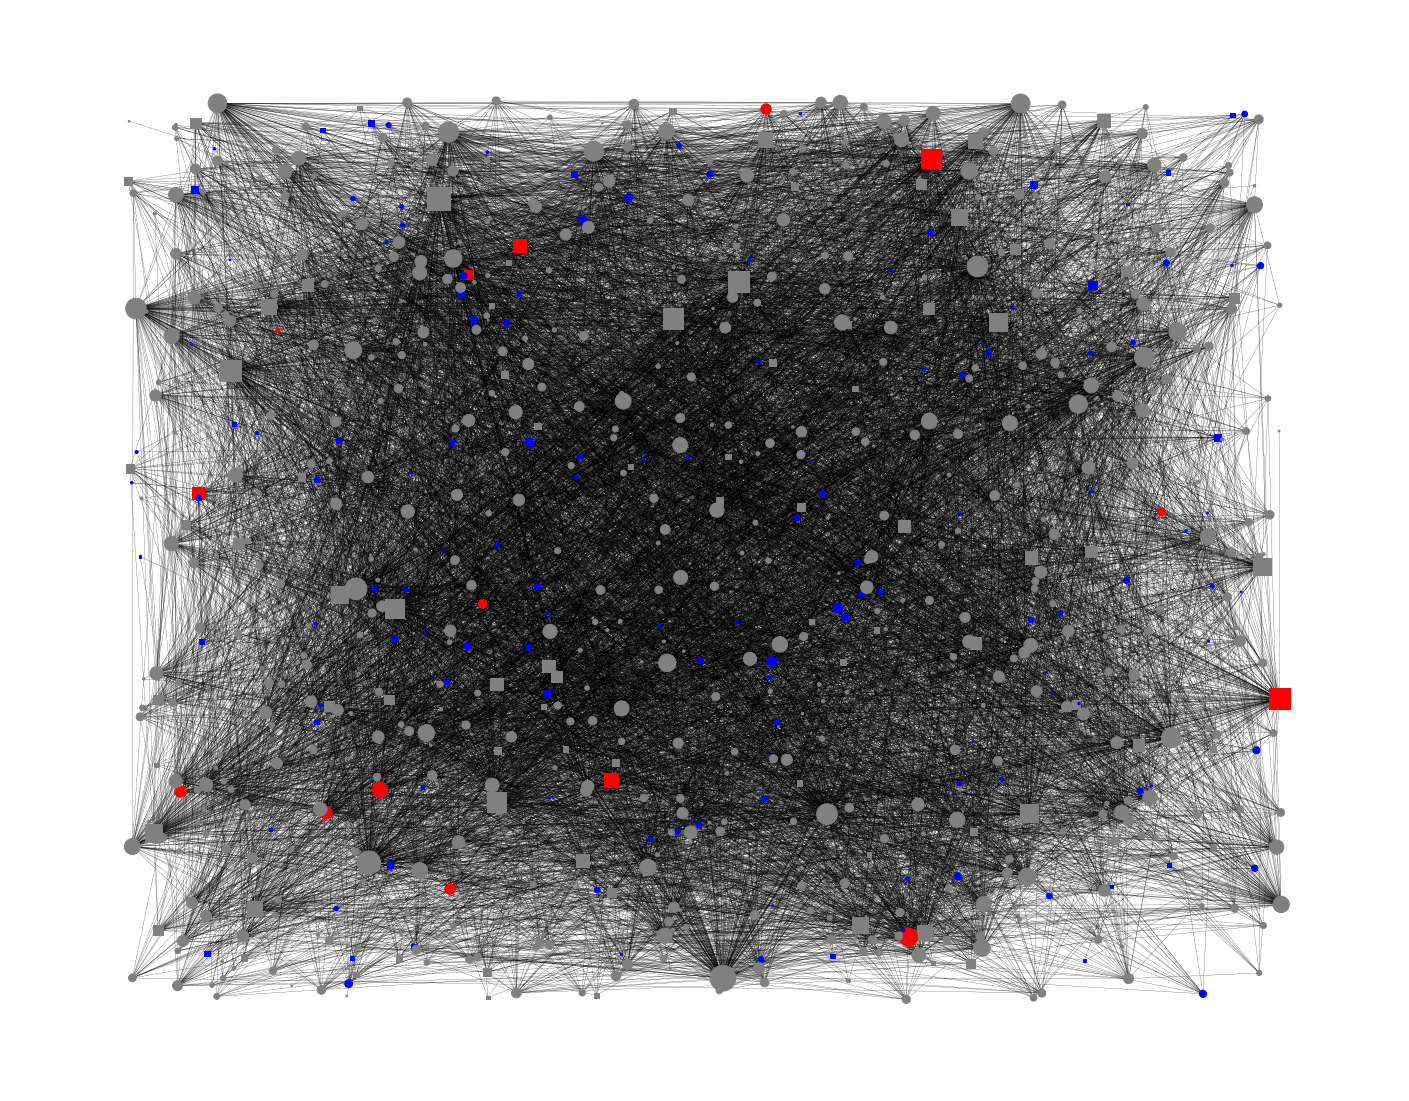

In [29]:
### OLD GRAPH - DO NOT RUN

fig, ax = plt.subplots(1)
fig.set_size_inches(25, 20)
pos = nx.random_layout(G_copy)
nx.draw(
    G_copy,
    pos=pos,
    nodelist=[],
    width=0.2, node_size=15, arrowsize=10, ax=ax
)
nx.draw_networkx_nodes(G_copy, pos, node_shape='s',
                       node_size=[len(list(G_copy.neighbors(x)))*3
                                  for x, target in G_copy.nodes(data='target') if target],
                       nodelist=[x for x, target in G_copy.nodes(data='target') if target],
                       node_color=[x[1]['color'] for x in G_copy.nodes(data=True) if x[1]['target']], ax=ax)
nx.draw_networkx_nodes(G_copy, pos, node_shape='o',
                       node_size=[len(list(G_copy.neighbors(x)))*3
                                  for x, target in G_copy.nodes(data='target') if not target],
                       nodelist=[x for x, target in G_copy.nodes(data='target') if not target],
                       node_color=[x[1]['color'] for x in G_copy.nodes(data=True) if not x[1]['target']], ax=ax)

### Save the graph

In [25]:
nx.write_gpickle(G_copy, 'data/protein_graph')